In [1]:
## Importing needed libraries
import pandas as pd
import datetime
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
## Importing needed files
directory = 'C:/Users/viks9/Downloads/retailrocket/'

def importData(file):
    return pd.read_csv(directory + file + '.csv')

category_tree = importData('category_tree')
events = importData('events')
items1 = importData('item_properties_part1')
items2 = importData('item_properties_part2')
items_properties = pd.concat([items1, items2])

### Exploring and Cleaning Data

In [3]:
category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [4]:
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [5]:
## Converting time stamp columns from UNIX format and sorting values by the timestamp
import datetime
events_times =[]
for i in events['timestamp']:
    events_times.append(datetime.datetime.fromtimestamp(i//1000.0)) 
events['timestamp'] = events_times

events = events.sort_values(by = 'timestamp')

In [6]:
events.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

We have 2733644 null values in the transactionid column, we will explore this more below.

In [7]:
events[events['transactionid'].isnull()].head()

,timestamp,visitorid,event,itemid,transactionid
1462974,2015-05-02 22:00:04,693516,addtocart,297662,NaN
1464806,2015-05-02 22:00:11,829044,view,60987,NaN
1463000,2015-05-02 22:00:13,652699,view,252860,NaN
1465287,2015-05-02 22:00:24,1125936,view,33661,NaN
1462955,2015-05-02 22:00:26,693516,view,297662,NaN


In [8]:
events['event'].value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [9]:
## Calculating amount of transactions
non_transaction_events = events['event'].size - events['event'].value_counts()['transaction']
print("There were " + str(non_transaction_events) + " events that did not result in a transaction.")

There were 2733644 events that did not result in a transaction.


Null transaction ID's occur when an event is a view or addedtocart.

In [10]:
## Calculating percentage of events that resulted in a transaction
percent_purchased = len(events[events['event'] == 'transaction']) / len(events[events['event'] != 'transaction']) * 100
print("Only " + str("{:.2f}".format(percent_purchased)) + "% of events resulted in a purchase")

Only 0.82% of events resulted in a purchase


In [11]:
items_properties.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


The category tree dataframe does not have an itemid for us to reference, so we will get the categoryid's from the items_properties dataframe. When the property is categoryid, the value will be the items categoryid. 

In [12]:
## Creating a dataframe for category ids
category_ids = items_properties[items_properties['property'] == 'categoryid']
category_ids = category_ids.rename(columns={"value": "categoryid"})
category_ids = category_ids.drop(['timestamp', 'property'], axis = 1)
category_ids = category_ids.set_index('itemid')
category_ids.head()

,categoryid
itemid,
460429,1338
281245,1277
35575,1059
8313,1147
55102,47


In [13]:
## Converting time stamp columns from UNIX format and sorting values by the timestamp
items_times = []
for i in items_properties['timestamp']:
    items_times.append(datetime.datetime.fromtimestamp(i//1000.0)) 
items_properties['timestamp'] = items_times

## Splitting Events Dataframe for events that resulted in transaction and did not result in a transaction

### Resulted in a transaction


In [14]:
## Customers that made a transaction
customer_purchased = (events['visitorid'][events['event'] == 'transaction'].unique())

print(str(len(customer_purchased)) + (" customers made ") + str((events['event'] == 'transaction').sum()) + " purchases")

11719 customers made 22457 purchases


In [15]:
## Creating a dataframe of the events for visitors that made a purchase
transaction_df = events[events['visitorid'].isin(customer_purchased)]
transaction_df.head()

,timestamp,visitorid,event,itemid,transactionid
1462684,2015-05-02 22:03:20,41386,view,340921,NaN
1462673,2015-05-02 22:09:28,345781,view,438400,NaN
1464340,2015-05-02 22:11:33,345781,addtocart,438400,NaN
1464573,2015-05-02 22:15:30,560305,view,43939,NaN
1464908,2015-05-02 22:23:57,266417,view,445106,NaN


In [16]:
## Viewing a customer that purchased 
events[events['visitorid'] == random.choice(customer_purchased)]

,timestamp,visitorid,event,itemid,transactionid
2409535,2015-07-15 15:04:29,1085279,view,348495,NaN
2403414,2015-07-15 16:22:48,1085279,view,348495,NaN
2395676,2015-07-15 19:08:30,1085279,view,348495,NaN
2374182,2015-07-16 15:40:24,1085279,transaction,348495,3509.0


### Did not result in transaction 

In [17]:
## Customers that did not make a transaction
customer_not_purchased = [customer for customer in events['visitorid'].unique() if customer not in customer_purchased] ## Use not in to not double count customers that viewed and made transaction 

print(str(len(customer_not_purchased)) + (" customers did not make a purchase during ") + str((events['event'] != 'transaction').sum()) + " visits")

1395861 customers did not make a purchase during 2733644 visits


In [18]:
## Creating a dataframe of events for visitors that did not make a transaction
no_transaction_df = events[events['visitorid'].isin(customer_not_purchased)]
no_transaction_df.head()

,timestamp,visitorid,event,itemid,transactionid
1462974,2015-05-02 22:00:04,693516,addtocart,297662,NaN
1464806,2015-05-02 22:00:11,829044,view,60987,NaN
1463000,2015-05-02 22:00:13,652699,view,252860,NaN
1465287,2015-05-02 22:00:24,1125936,view,33661,NaN
1462955,2015-05-02 22:00:26,693516,view,297662,NaN


In [19]:
## Viewing a customer that did not make a purchase 
events[events['visitorid'] == random.choice(customer_not_purchased)]

,timestamp,visitorid,event,itemid,transactionid
846812,2015-08-14 12:05:24,692037,view,53987,NaN


## Finding products that were bought together

In [20]:
## Creating a dataframe of transactions
transaction_occured = transaction_df[transaction_df['event'] == 'transaction']
transaction_occured.head()

,timestamp,visitorid,event,itemid,transactionid
1465072,2015-05-02 22:27:21,869008,transaction,40685,9765.0
1463096,2015-05-02 22:35:01,345781,transaction,438400,1016.0
1464289,2015-05-02 23:01:47,586756,transaction,440917,10942.0
1463462,2015-05-02 23:07:38,435495,transaction,175893,6173.0
1463605,2015-05-02 23:31:14,266417,transaction,445106,12546.0


In [21]:
## Creating a list of lists of products that customers bought
purchased_together = []

for customer in customer_purchased:
    purchased_together.append(list(transaction_occured.loc[transaction_occured['visitorid'] == customer, 'itemid']))

In [22]:
## Creating a function to find other items that customers purchased with a product. 
def productRecommender(itemid, purchased_together):
    recommended_products = []
    for item_list in purchased_together:
        if itemid in item_list:
            for item in item_list:
                if item != itemid:
                    recommended_products.append(item)
    return recommended_products

In [23]:
## Products that were bought for product 179400
print("Products that were bought together with 179400: " + str(productRecommender(445106, purchased_together)))

Products that were bought together with 179400: [301359, 238951, 117762]


## Creating a function to build a dataframe describing customer actions

In [24]:
def creatingDataframe(customer_list):
    ## Building temperary df of customers events from customer list
    temp_df = events[events['visitorid'].isin(customer_list)]
    
    customer_df = pd.DataFrame()
    customer_df['visitorid'] = customer_list
    customer_df = customer_df.set_index('visitorid')
    
    #Calculating number of products the customer viewed
    num_products = temp_df.pivot_table(values = 'itemid', index = 'visitorid', aggfunc = lambda x: len(x.unique()))
    
    ## Calculating frequency of total customers views
    views = temp_df[temp_df['event'] == 'view'].groupby('visitorid').count()['event']
    
    ## Calculating frequency of a customers views
    added_to_cart = temp_df[temp_df['event'] == 'addtocart'].groupby('visitorid').count()['event']
    
    ## Calculating frequency of a customers transactions
    transaction_frequency = temp_df[temp_df['event'] == 'transaction'].groupby('visitorid').count()['event']
    
    
    
    
    customer_df = pd.concat([customer_df,
                             num_products,
                             views.rename('view_frequency'),
                             added_to_cart.rename('added_to_cart_frequency'),
                             transaction_frequency.rename('transaction_frequency')], axis=1, ignore_index = False)
    customer_df = customer_df.rename(columns = {'itemid' : 'num_products'})
    customer_df = customer_df.fillna(0)
    
    ## Returns a one if a customer made a purchase and a zero if no purchase was made
    customer_df['purchased'] = customer_df['transaction_frequency'].apply(lambda row: 1 if row > 0 else 0)
    return customer_df
    

In [25]:
## Customer actions of a customer that made a purchase
purchasing_visitors = creatingDataframe(customer_purchased)
purchasing_visitors.head()

,num_products,view_frequency,added_to_cart_frequency,transaction_frequency,purchased
visitorid,,,,,
172,22,33.0,3.0,2,1
186,1,2.0,1.0,1,1
264,2,3.0,2.0,2,1
419,3,4.0,1.0,1,1
539,1,4.0,2.0,1,1


In [26]:
## Customer actions of a customer that did not make a purchase
non_purchasing_visitors = creatingDataframe(customer_not_purchased)
non_purchasing_visitors.head()

,num_products,view_frequency,added_to_cart_frequency,transaction_frequency,purchased
visitorid,,,,,
0,3,3.0,0.0,0.0,0
1,1,1.0,0.0,0.0,0
2,4,8.0,0.0,0.0,0
3,1,1.0,0.0,0.0,0
4,1,1.0,0.0,0.0,0


In [27]:
## Randomizing and slicing the non_purchasing_visitors dataframe and combining it with the purchasing_visitors dataframe
non_purchasing_visitors = non_purchasing_visitors.sample(frac=1)[:28000]
full_customer_df = pd.concat([purchasing_visitors, non_purchasing_visitors], ignore_index=True)
full_customer_df = full_customer_df.sample(frac=1)

## Predicting if a visitor will make a purchase

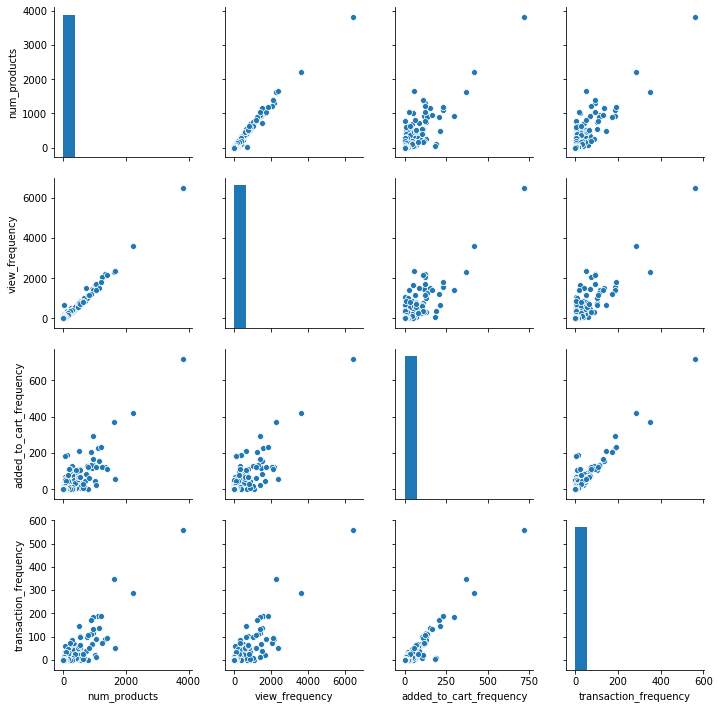

In [28]:
sns.pairplot(full_customer_df.drop('purchased', axis ='columns'))

In [29]:
full_customer_df.corr()

,num_products,view_frequency,added_to_cart_frequency,transaction_frequency,purchased
num_products,1.000000,0.991236,0.859700,0.875136,0.098504
view_frequency,0.991236,1.000000,0.862737,0.870534,0.106135
added_to_cart_frequency,0.859700,0.862737,1.000000,0.954665,0.161899
transaction_frequency,0.875136,0.870534,0.954665,1.000000,0.178867
purchased,0.098504,0.106135,0.161899,0.178867,1.000000


We will only use the view_frequency in our prediction model. The other variables will be dropped because of multicollinearity. 

In [30]:
data = ['view_frequency']
target = 'purchased'

In [31]:
logreg = LogisticRegression(solver='lbfgs')

In [32]:
## Splitting the data set 50/50 into a train and test dataset
train = full_customer_df[:27803]
test = full_customer_df[27803:]

In [33]:
logreg.fit(train[data], train[target])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
predictions = logreg.predict(test[data])
accuracy = metrics.accuracy_score(test[target], predictions) * 100
print("Prediction accuracy: " + str("{:.2f}".format(accuracy)) + "%")

Prediction accuracy: 79.26%


# Takeaways

### We will be using the below image to aid us in making the proper decisions

In [35]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i0.wp.com/www.digitalnoobs.com/wp-content/uploads/2015/09/buyer-decision-process.gif?resize=500%2C750")

The picture displays the 5 stages a buyer encounters in their buying decision process. The picutre is from: https://i0.wp.com/www.digitalnoobs.com/wp-content/uploads/2015/09/buyer-decision-process.gif?resize=500%2C750

### Visitor logs on and begins searching

When the visitor first logs on, we can recommend the most viewed products on the site from that week. 

In [36]:
from datetime import timedelta
start_date = events['timestamp'][events.index[-1]]
end_date = start_date + timedelta(days=-7)
last_week = events[(events['timestamp'] >= end_date) & (events['timestamp'] <= start_date)]

featured_items = (last_week[last_week['event'] == 'view']['itemid'].value_counts())
print("This weeks most viewed items: ")
print(featured_items[:10])

print("\nWe will begin by showing the following items: " + str(list(featured_items.index)[:10]))

This weeks most viewed items: 
434782    419
17114     384
187946    250
461686    171
245085    153
320130    132
9877      108
96924     102
314579    102
76060     101
Name: itemid, dtype: int64

We will begin by showing the following items: [434782, 17114, 187946, 461686, 245085, 320130, 9877, 96924, 314579, 76060]


### Visitor begins looking at itemid: 461686

In [37]:
## Finding the most viewed related products
recommended_items = productRecommender(461686, purchased_together)
top_recommended = pd.Series(recommended_items).value_counts()
print("\nWe will show the following products that are commonly bought together with product 461686: " + str(list(top_recommended.index)[:10]))


We will show the following products that are commonly bought together with product 461686: [119736, 10572, 171878, 32581, 218794, 320130, 248455, 357529, 420960, 124081]


### Visitor is on Stage 2 and begins looking at itemid: 10572

In [38]:
print(category_ids.loc[[10572, 461686]])

       categoryid
itemid           
10572        1037
461686       1037


We can see now that the visitor is looking at products within the same category, so the visitor is now moving to Stage 2. We will now recommend popular products from the category. 

In [39]:
## Finding the most viewed products from categoryid 1037
currently_viewing = [10572]
merged_events = events.merge(right = category_ids, how = 'left', on ='itemid')
category_values = merged_events[merged_events['categoryid'] == '1037']
top_category_items = category_values[category_values['event'] == 'view']['itemid'].value_counts().index
top_items = [item for item in top_category_items if item not in currently_viewing][:10]
print("We will recommend the following products: " + str(top_items))

We will recommend the following products: [461686, 422376, 218794, 171878, 32581, 271872, 67423, 285154, 307322, 75392]


### Visitor continues viewing products popular from the category and is moving on to Stage 3

If we had the available data, we would now recommend products within the same category that are the most similar in price. 

### At this point, the customer would have viewed atleast 4 items. We will look at how are strategy performed compared to our test dataset. 

In [40]:
test['view_frequency'].describe()

count    11916.000000
mean         6.057654
std         57.773952
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       2368.000000
Name: view_frequency, dtype: float64

We will look at the distribution of the view frequencies and see if the mean is a good variable to compare our perfomance too.

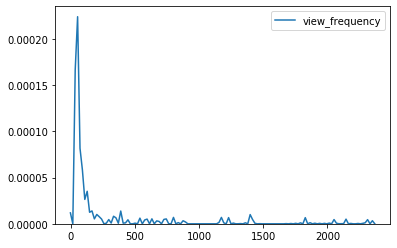

In [41]:
sns.kdeplot(test['view_frequency'])

The distribution is heavily skewed, so we will look at the median instead.

In [42]:
print("The median of the data set is: " + str((test['view_frequency']).median()))

The median of the data set is: 1.0


We can see above, that if our strategy performs as planned, it would result in getting more views from a visitor than 75% of visitors from the test dataframe, and we would have at least 3 more views than the median of the test dataframe. 

In [43]:
## if the visitor has 4 views
four_views = test[test['view_frequency'] == 4]['purchased'].value_counts().loc[1] / test[test['view_frequency'] == 4]['purchased'].size * 100
print("From our test dataset, when a visitor had 4 views, the visitor made a transaction " + str("{:.2f}".format(four_views)) + "% of the time")

## if the visitor has 5 views
five_views = test[test['view_frequency'] == 5]['purchased'].value_counts().loc[1] / test[test['view_frequency'] == 5]['purchased'].size * 100
print("From our test dataset, when a visitor had 5 views, the visitor made a transaction " + str("{:.2f}".format(five_views)) + "% of the time")

## if the visitor has 6 views
six_views = test[test['view_frequency'] == 6]['purchased'].value_counts().loc[1] / test[test['view_frequency'] == 6]['purchased'].size * 100
print("From our test dataset, when a visitor had 6 views, the visitor made a transaction " + str("{:.2f}".format(six_views)) + "% of the time")

From our test dataset, when a visitor had 4 views, the visitor made a transaction 56.05% of the time
From our test dataset, when a visitor had 5 views, the visitor made a transaction 62.29% of the time
From our test dataset, when a visitor had 6 views, the visitor made a transaction 68.58% of the time


## The strategy in action

In [44]:
## Activity from visitor 1217315
events[events['visitorid'] == 1217315].merge(right = category_ids, how = 'left', on = 'itemid')

,timestamp,visitorid,event,itemid,transactionid,categoryid
0,2015-09-15 09:46:37,1217315,view,461686,NaN,1037
1,2015-09-15 09:47:10,1217315,view,10572,NaN,1037
2,2015-09-15 09:49:59,1217315,view,461686,NaN,1037
3,2015-09-15 09:50:25,1217315,view,10572,NaN,1037
4,2015-09-15 09:54:36,1217315,view,461686,NaN,1037
5,2015-09-15 09:56:08,1217315,addtocart,461686,NaN,1037
6,2015-09-15 09:57:21,1217315,view,32581,NaN,1037
7,2015-09-15 09:58:02,1217315,addtocart,32581,NaN,1037
8,2015-09-15 10:01:13,1217315,transaction,461686,7909.0,1037
9,2015-09-15 16:21:06,1217315,view,10572,NaN,1037


#### In the above dataframe, we can see an example of the scenario playing out. The visitor began by viewing a popular item, itemid 461686, clicked on a popular similar item, went back and forth between the two (Stage 2), looked at another similar item from the category (Stage 3), and ended up purchasing the product (Stage 4). 